In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from proglearn.voters import TreeClassificationVoter
from proglearn.deciders import SimpleAverage

from sklearn.metrics import accuracy_score

from utils import load_embedded_data

In [2]:
X_train, y_train, X_test, y_test = load_embedded_data(split_train=True, split_test=True)

X_train shape: (10, 5000, 1000)
y_train shape: (10, 5000, 1)
X_test shape: (10, 1000, 1000)
y_test shape: (10, 1000, 1)


In [3]:
lf = pickle.load(open("output/lf_task_10.p", "rb"))

In [4]:
# For each task
# Check the performance of... 

# UF (LF with transformer ids = t)
# LF (all transformers)
# The best out of either of them.
# The best out of UF, LF, some random ones with UF and LF in the mix.

In [28]:
def sample_transformer_ids(task_id):
    transformer_ids = [task_id]
    for t in range(10):
        if np.random.binomial(1, 0.5) and t != task_id:
            transformer_ids.append(t)
    return transformer_ids

In [29]:
def get_te(task_id, num_candidates = 10, verbose = False):
    
    if verbose:
        print("Task %d" % task_id)
        print("--------------------")
    
    train_x = X_train[task_id][0:4500]
    train_y = y_train[task_id][0:4500]
    
    val_x = X_train[task_id][4500:]
    val_y = y_train[task_id][4500:]
    
    test_y = y_test[task_id]
    test_x = X_test[task_id]
    
    # Method 1: UF
    if verbose: print("Running Method 1: UF...")
    uf_pred = lf.predict(test_x, task_id, transformer_ids = [task_id])
    uf_acc = accuracy_score(uf_pred, test_y)
    
    # Method 2: LF
    if verbose: print("Running Method 2: LF...")
    lf_pred = lf.predict(test_x, task_id)
    lf_acc = accuracy_score(lf_pred, test_y)
    
    # Method 3: Pick the best on the training set between LF and UF.
    if verbose: print("Running Method 3: One-vs-All (train)...")
    lf_train_acc = accuracy_score(lf.predict(train_x, task_id), train_y)
    uf_train_acc = accuracy_score(lf.predict(train_x, task_id, transformer_ids = [task_id]), train_y)
    if uf_train_acc > lf_train_acc:
        ova_train_acc = uf_acc
        ova_train_transformers = [task_id]
    else:
        ova_train_acc = lf_acc
        ova_train_transformers = np.arange(10)
    
    
    # Method 4: Pick the best on validation set between UF and LF.
    if verbose: print("Running Method 4: One-vs-All (val)...")
    lf_val_acc = accuracy_score(lf.predict(val_x, task_id), val_y)
    uf_val_acc = accuracy_score(lf.predict(val_x, task_id, transformer_ids = [task_id]), val_y)
    if uf_val_acc > lf_val_acc:
        ova_val_acc = uf_acc
        ova_val_transformers = [task_id]
    else:
        ova_val_acc = lf_acc
        ova_val_transformers = np.arange(10)
    
    
    # Method 5: Sample the best transformers based on the training set.
    if verbose: print("Running Method 5: Sample (train)...")
    best_acc = ova_train_acc
    best_transformer_ids = ova_train_transformers
    for c in range(num_candidates):
        transformer_ids = sample_transformer_ids(task_id)
        acc = accuracy_score(lf.predict(train_x, task_id, transformer_ids = transformer_ids), train_y)
        if acc > best_acc:
            best_acc = acc
            best_transformer_ids = transformer_ids
    sample_train_acc = accuracy_score(lf.predict(test_x, task_id, transformer_ids = best_transformer_ids), test_y)
    sample_train_transformed_ids = best_transformer_ids
            
    
    # Methpd 6: Sample the best transformers based on the validation set.
    if verbose: print("Running Method 6: Sample (val)...")
    best_acc = ova_val_acc
    best_transformer_ids = ova_val_transformers
    for c in range(num_candidates):
        transformer_ids = sample_transformer_ids(task_id)
        acc = accuracy_score(lf.predict(val_x, task_id, transformer_ids = transformer_ids), val_y)
        if acc > best_acc:
            best_acc = acc
            best_transformer_ids = transformer_ids
    sample_val_acc = accuracy_score(lf.predict(test_x, task_id, transformer_ids = best_transformer_ids), test_y)
    sample_val_transformed_ids = best_transformer_ids
    
    results = {
        'lf_te' : (1 - uf_acc) / (1 - lf_acc),
        'ova_train_te' : (1 - uf_acc) / (1 - ova_train_acc),
        'ova_val_te' : (1 - uf_acc) / (1 - ova_val_acc),
        'sample_train_te' : (1 - uf_acc) / (1 - sample_train_acc),
        'sample_val_te' : (1 - uf_acc) / (1 - sample_val_acc)
    }
    
    pickle.dump(results, open("output/robust_result_%d.p" % task_id, "wb"))
    
    print(results)

In [30]:
def plot_te(ax, task_id):
    
    results = pickle.load(open("output/robust_result_%d.p" % task_id, "rb"))
    
    x = 0.3 * np.arange(5)
    width = 0.2

    ax.bar(x[0], results['lf_te'], width=width, color='#d7191c', align='center', label = 'LF')
    ax.bar(x[1], results['ova_train_te'], width=width, color='#fdae61', align='center', label = 'OvA Train')
    ax.bar(x[2], results['ova_val_te'], width=width, color='#ffffbf', align='center', label = 'OvA Val')
    ax.bar(x[3], results['sample_train_te'], width=width, color='#abd9e9', align='center', label = 'Sample Train')
    ax.bar(x[4], results['sample_val_te'], width=width, color='#2c7bb6', align='center', label = 'Sample Val')
    
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_xticklabels([])
    
    ax.set_xlabel("Task %d" % task_id)
    # ax.set_ylabel("Transfer Efficiency")
    ax.set_ylim(0.5, 1.5)
    
    ax.axhline(y=1, color = 'k')

    # ax.set_title("L2F+ResNet50 Encoded Split-CIFAR, n_trees=300, n_train=5000")
    # plt.savefig("te_fig.pdf", bbox_inches = "tight")
    # plt.show()

In [31]:
for t in [0, 1, 2, 3, 4]:
    get_te(t, verbose=True)

Task 0
--------------------
Running Method 1: UF...
Running Method 2: LF...
Running Method 3: One-vs-All (train)...
Running Method 4: One-vs-All (val)...
Running Method 5: Sample (train)...
Running Method 6: Sample (val)...
{'lf_te': 0.7791411042944784, 'ova_train_te': 0.7791411042944784, 'ova_val_te': 1.0, 'sample_train_te': 1.007936507936508, 'sample_val_te': 0.888111888111888}
Task 1
--------------------
Running Method 1: UF...
Running Method 2: LF...
Running Method 3: One-vs-All (train)...
Running Method 4: One-vs-All (val)...
Running Method 5: Sample (train)...
Running Method 6: Sample (val)...
{'lf_te': 1.0056818181818181, 'ova_train_te': 1.0, 'ova_val_te': 1.0056818181818181, 'sample_train_te': 1.1062500000000002, 'sample_val_te': 1.023121387283237}
Task 2
--------------------
Running Method 1: UF...
Running Method 2: LF...
Running Method 3: One-vs-All (train)...
Running Method 4: One-vs-All (val)...
Running Method 5: Sample (train)...
Running Method 6: Sample (val)...
{'lf_te':

In [32]:
for t in [5, 6, 7, 8, 9]:
    get_te(t, verbose=True)

Task 5
--------------------
Running Method 1: UF...
Running Method 2: LF...
Running Method 3: One-vs-All (train)...
Running Method 4: One-vs-All (val)...
Running Method 5: Sample (train)...
Running Method 6: Sample (val)...
{'lf_te': 0.844621513944223, 'ova_train_te': 1.0, 'ova_val_te': 1.0, 'sample_train_te': 0.9257641921397379, 'sample_val_te': 1.0}
Task 6
--------------------
Running Method 1: UF...
Running Method 2: LF...
Running Method 3: One-vs-All (train)...
Running Method 4: One-vs-All (val)...
Running Method 5: Sample (train)...
Running Method 6: Sample (val)...
{'lf_te': 0.9330543933054393, 'ova_train_te': 1.0, 'ova_val_te': 1.0, 'sample_train_te': 0.9570815450643776, 'sample_val_te': 1.009049773755656}
Task 7
--------------------
Running Method 1: UF...
Running Method 2: LF...
Running Method 3: One-vs-All (train)...
Running Method 4: One-vs-All (val)...
Running Method 5: Sample (train)...
Running Method 6: Sample (val)...
{'lf_te': 0.9216589861751151, 'ova_train_te': 0.92165

In [33]:
def plot_figure():
    sns.set(font_scale = 1)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [12, 5] # TODO: Tune
    fig, axes = plt.subplots(2, 5)
    
    for t in range(5):
        plot_te(axes[0, t], t)
        plot_te(axes[1, t], t + 5)
    
    # axes[1, 0].legend(loc = "lower left")
    axes[0, 4].legend(bbox_to_anchor=(1, 1))
    
    axes[0, 0].set_ylabel('Transfer Efficiency')
    axes[1, 0].set_ylabel('Transfer Efficiency')
    axes[0, 0].set_yticks([0.5, 1, 1.5])
    axes[1, 0].set_yticks([0.5, 1, 1.5])
    
    plt.tight_layout()
    plt.savefig("robust_fig.pdf", bbox_inches = "tight")
    plt.show()

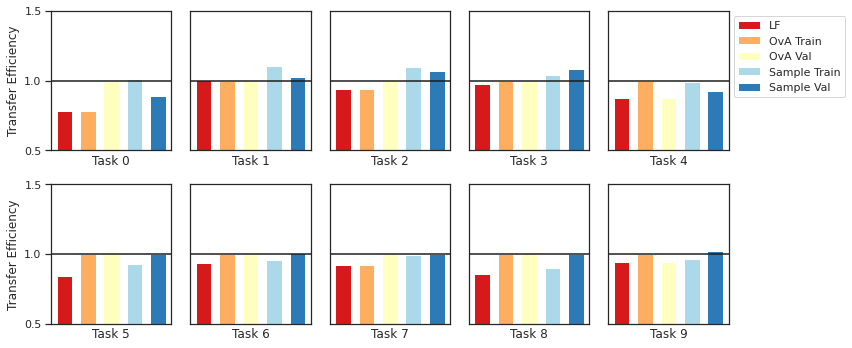

In [34]:
plot_figure()